# Notebook to check the methods for calculating surface normalized vertical vorticity with ROMS model output

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
import netCDF4
from datetime import datetime

import glob
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

plt.rcParams.update({'font.size': 12})
crs = ccrs.PlateCarree(central_longitude=-93.5)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36776 instead
  warnings.warn(


## Open model output - native TXLA (not nested)

In [2]:
#Parent grid - not associated with the child grid. 
paths = glob.glob('/d1/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his_00*.nc')

ds_parent = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_parent, grid_parent = xroms.roms_dataset(ds_parent, Vtransform = 2)

model_time = datetime(2010, 6, 20, 12)

## Method 1: Use xroms, but not the built in xroms.relative_vorticity function we only care about the surface value. If we used more than the surface, we need to use xroms.hgrad because the '...ROMS vertical coordinates are s-coordinates and therefore can vary in time and space.'

In [3]:
u = ds_parent.u.isel(s_rho=-1).sel(ocean_time=model_time)
v = ds_parent.v.isel(s_rho=-1).sel(ocean_time=model_time)

dudy = grid_parent.derivative(u, 'Y')
dvdx = grid_parent.derivative(v, 'X')
f_psi = xroms.to_psi(ds_parent.f, grid_parent)

rvort_psi = (dvdx-dudy)/f_psi

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


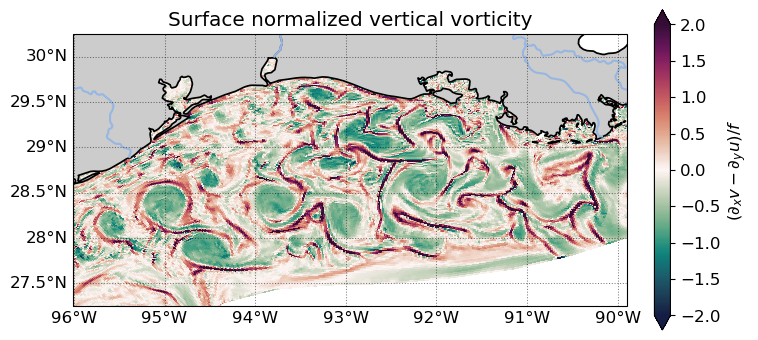

In [4]:
fig,ax = plt.subplots(1, dpi = 100, figsize = (8,3.5), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax.pcolormesh(ds_parent.lon_psi, ds_parent.lat_psi, rvort_psi, cmap = cmo.curl,
                         vmin = -2, vmax = 2, 
                         transform = ccrs.PlateCarree())

cb = fig.colorbar(ax = ax, mappable = mappable, label = r'$(\partial_x v - \partial_y u)/f$', extend = 'both',)
ax.set_extent([-96.01, -89.9, 27.25, 30.25], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m', linewidth = 1.25)  
ax.add_feature(states_provinces, linewidth=1.25)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.25)
ax.add_feature(cfeature.RIVERS, linewidth=1.5)

gl = ax.gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.set_title('Surface normalized vertical vorticity')
fig.show()

## Looking good so far - now let's check with pure xarray and numpy

In [5]:
#Open the model output with pure xarray
path = glob.glob('/d1/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his*.nc')
da = xr.open_mfdataset(path)
model_time = datetime(2010, 6, 20, 12)

lon_rho = da.lon_rho.values
lat_rho = da.lat_rho.values
lon_psi = da.lon_psi.values
lat_psi = da.lat_psi.values

f = da.f[0].values
pm = da.pm[0].values
pn = da.pn[0].values

u = da.u.isel(s_rho=-1).sel(ocean_time=model_time).values
v = da.v.isel(s_rho=-1).sel(ocean_time=model_time).values

dudy = np.diff(u, axis=-2)*0.25*(pn[:-1,:-1]+pn[1:,:-1]+pn[:-1,1:]+pn[1:,1:])
dvdx = np.diff(v, axis=-1)*0.25*(pm[:-1,:-1]+pm[1:,:-1]+pm[:-1,1:]+pm[1:,1:])
zeta = (dvdx - dudy)/(0.25*(f[:-1,:-1]+f[1:,:-1]+f[:-1,1:]+f[1:,1:]))

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


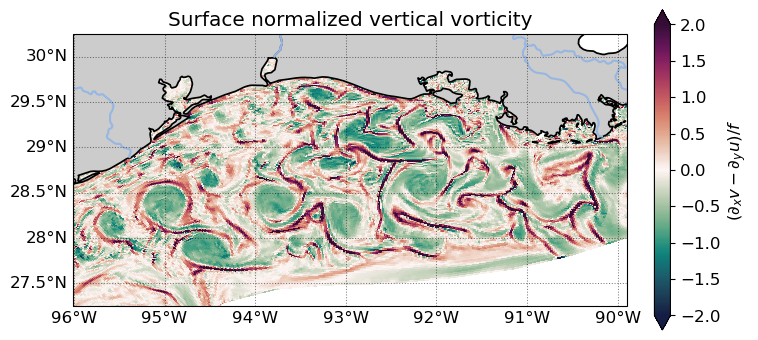

In [6]:
fig,ax = plt.subplots(1, dpi = 100, figsize = (8,3.5), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax.pcolormesh(lon_psi, lat_psi, zeta, cmap = cmo.curl,
                         vmin = -2, vmax = 2, 
                         transform = ccrs.PlateCarree())

cb = fig.colorbar(ax = ax, mappable = mappable, label = r'$(\partial_x v - \partial_y u)/f$', extend = 'both',)
ax.set_extent([-96.01, -89.9, 27.25, 30.25], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m', linewidth = 1.25)  
ax.add_feature(states_provinces, linewidth=1.25)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.25)
ax.add_feature(cfeature.RIVERS, linewidth=1.5)

gl = ax.gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.set_title('Surface normalized vertical vorticity')
fig.show()

## Now examine their differences. Just substract the two and print the outputs, then plot the difference to make sure it doesn't blow up

In [7]:
rv_diff = zeta-rvort_psi.values
rv_diff

array([[-6.93889390e-18,  0.00000000e+00, -1.38777878e-17, ...,
        -4.44089210e-16,  0.00000000e+00,  0.00000000e+00],
       [ 6.93889390e-18, -1.38777878e-17, -3.46944695e-18, ...,
         2.22044605e-16,  0.00000000e+00,  2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00, -1.38777878e-17, ...,
         1.11022302e-16,  1.38777878e-16, -2.22044605e-16],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

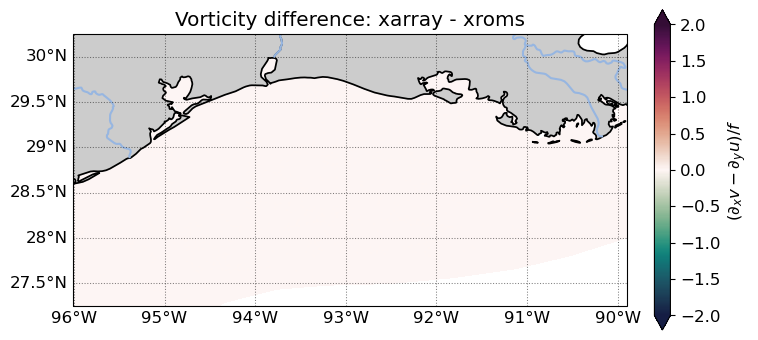

In [8]:
fig,ax = plt.subplots(1, dpi = 100, figsize = (8,3.5), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax.pcolormesh(lon_psi, lat_psi, rv_diff, cmap = cmo.curl,
                         vmin = -2, vmax = 2, 
                         transform = ccrs.PlateCarree())

cb = fig.colorbar(ax = ax, mappable = mappable, label = r'$(\partial_x v - \partial_y u)/f$', extend = 'both',)
ax.set_extent([-96.01, -89.9, 27.25, 30.25], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m', linewidth = 1.25)  
ax.add_feature(states_provinces, linewidth=1.25)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.25)
ax.add_feature(cfeature.RIVERS, linewidth=1.5)

gl = ax.gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.set_title('Vorticity difference: xarray - xroms')
fig.show()

## Great! Now let's explain what's happening. Consider the picture of the Arakawa-C grid below: 
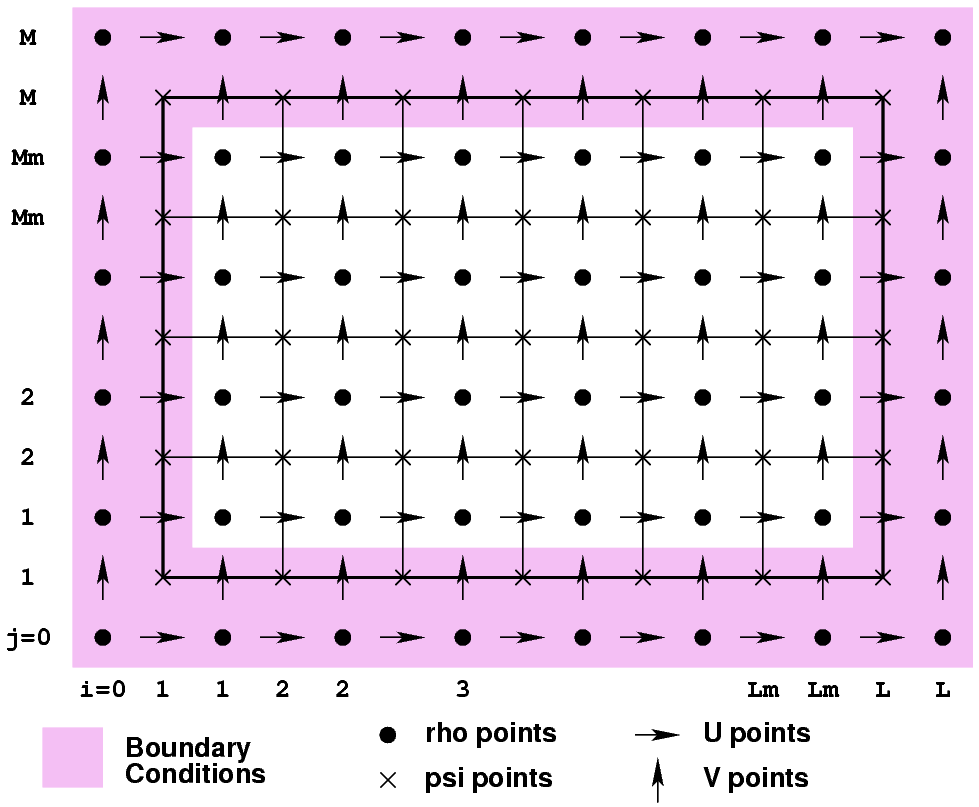

## When calculating $\partial_x v$ and $\partial_y u$, the discrete difference causes the derivatives to be on the cell edges, or the $\psi$ points. Now when you look at the indexing with xroms, it calls the psi points 'eta_v' and 'xi_u', which can be misleading. Another source of confusion is that XROMS renames some of the coordinates, for example:     
1. if "eta_u" in ds.dims:
        rename["eta_u"] = "eta_rho"
2. if "xi_v" in ds.dims:
        rename["xi_v"] = "xi_rho"
3. if "xi_psi" in ds.dims:
        rename["xi_psi"] = "xi_u"
4. "eta_psi" in ds.dims:
        rename["eta_psi"] = "eta_v"

## Now let's write a quick function for surface vorticity and make sure it equals the unfunctionalized version 

In [9]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface normalized vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds_parent.u.isel(s_rho=-1)
    v = ds_parent.v.isel(s_rho=-1)

    dudy = grid_parent.derivative(u, 'Y')
    dvdx = grid_parent.derivative(v, 'X')
    f_psi = xroms.to_psi(ds_parent.f, grid_parent)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

In [10]:
rvort_psi = surface_vorticity(ds_parent, grid_parent).sel(ocean_time = model_time)

rvort_psi.values-zeta

array([[ 6.93889390e-18,  0.00000000e+00,  1.38777878e-17, ...,
         4.44089210e-16,  0.00000000e+00,  0.00000000e+00],
       [-6.93889390e-18,  1.38777878e-17,  3.46944695e-18, ...,
        -2.22044605e-16,  0.00000000e+00, -2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00,  1.38777878e-17, ...,
        -1.11022302e-16, -1.38777878e-16,  2.22044605e-16],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])